# <center> Projet 6: Analysez les ventes d'une librairie </center>
Ce notebook traite de la partie de l'analyse bivariée
# Sommaire :
 - <a href="#C1">Importation des données</a>
 - <a href="#C2">Vérification type des données</a>
<ol>
     <li> <a href="#D1">Customer2</a> </li>
     <li> <a href="#D4">m_product_transaction</a> </li>
</ol><br>
 - <a href="#C7">Analyse bivariée</a>
<ol>
    <li> <a href="#D15">Genre et catégorie</a> </li>
    <ol>
        <li> <a href="#E3">En nombre de livres</a> </li>
        <li> <a href="#E4">En chiffre d'affaires</a> </li>
    </ol>
    <li> <a href="#D16">Genre et montant total</a> </li>
    <li> <a href="#D17">Age et montant total</a> </li>
    <li> <a href="#D18">Age et fréquence</a> </li>
    <li> <a href="#D19">Age et panier moyen</a> </li>
    <li> <a href="#D20">Age et catégorie</a> </li>
    <li> <a href="#D21">Analyse en prenant en compte l'age au moment de l'achat</a> </li>
</ol>

# <a name="C1">Importation des données</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from bioinfokit.analys import stat
import random

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27),
            'axes.titlesize': 'x-large'})
color_blue = '\033[94m'
color_reset = '\033[0m'

In [3]:
customer2 = pd.read_csv("customer2.csv")
m_product_transaction = pd.read_csv("m_product_transaction.csv")

# <a name="C2">Vérification type des données</a>

## <p style="text-indent:50px;"><a name="D1">1. Customer</a></p>

In [4]:
customer2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8596 entries, 0 to 8595
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  8596 non-null   object 
 1   sex        8596 non-null   object 
 2   birth      8596 non-null   int64  
 3   age        8596 non-null   int64  
 4   group      8596 non-null   object 
 5   group2     8596 non-null   object 
 6   cat0       8596 non-null   float64
 7   cat1       8596 non-null   float64
 8   cat2       8596 non-null   float64
 9   total      8596 non-null   float64
 10  CAcat0     8596 non-null   float64
 11  CAcat1     8596 non-null   float64
 12  CAcat2     8596 non-null   float64
 13  CA         8596 non-null   float64
dtypes: float64(8), int64(2), object(4)
memory usage: 940.3+ KB


In [5]:
customer2["group"] = customer2["group"].astype('category')
customer2["group2"] = customer2["group2"].astype('category')

## <p style="text-indent:50px;"><a name="D4">2. M_product_transaction</a></p>

In [6]:
m_product_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632689 entries, 0 to 632688
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     632689 non-null  object 
 1   price       632689 non-null  float64
 2   categ       632689 non-null  float64
 3   date        632689 non-null  object 
 4   session_id  632689 non-null  object 
 5   client_id   632689 non-null  object 
 6   fdate       632689 non-null  object 
dtypes: float64(2), object(5)
memory usage: 33.8+ MB


In [7]:
m_product_transaction["date"] = pd.to_datetime(m_product_transaction["date"])

## <a name="C7">Analyse bivariée</a>
Pour mener à bien notre analyse, nous ne prendrons pas en compte les données d'octobre 2021.

In [8]:
#On créé un nouveau DataFrame qui ne conservera que les colonnes qui nous intéressent.
customer3 = customer2.copy()
customer3 = customer3[["client_id", "sex", "birth", "age", "group", "group2"]]

#Nombre de livres de chaque catégorie achetés par un client sans le mois d'octobre
for i in range(len(m_product_transaction.categ.unique())):
    customer3["cat" + str(i)] = customer3["client_id"].map(
        m_product_transaction.loc[(m_product_transaction["categ"] == i) &
                                  (~m_product_transaction.date.astype(str).str.startswith('2021-10')), ["client_id", "categ"]].
        groupby(by=["client_id"]).count().to_dict()["categ"])
    customer3["cat" + str(i)].fillna(0, inplace = True)

customer3["total"] = customer3["cat0"] + customer3["cat1"] + customer3["cat2"]

#Dépense totale dans chaque catégorie par client sans le mois d'octobre
for i in range(len(m_product_transaction.categ.unique())):
    customer3["CAcat" + str(i)] = customer3["client_id"].map(
        m_product_transaction.loc[(m_product_transaction["categ"] == i) & 
                                  (~m_product_transaction.date.astype(str).str.startswith('2021-10')), ["client_id", "price"]].
        groupby(by=["client_id"]).sum().to_dict()["price"])
    customer3["CAcat" + str(i)].fillna(0, inplace = True)
customer3["CA"] = customer3["CAcat0"] + customer3["CAcat1"] + customer3["CAcat2"]

#On supprime les clients qui n'ont rien acheté
customer3 = customer3.loc[customer3.CA != 0]

## <p style="text-indent:50px;"><a name="D15">1- Genre et catégorie</a></p>
Nous allons regarder s'il y a un lien entre le genre et la catégorie de livres achetés.
## <p style="text-indent:100px;"><a name="E3">A. en nombre de livres</a></p>

In [9]:
#Tableau de contingence
cont = customer3[["sex", "cat0", "cat1", "cat2", "total"]].groupby("sex").sum().T
cont["total"] = cont.sum(axis=1)
cont

sex,f,m,total
cat0,192025.0,178044.0,370069.0
cat1,110550.0,100227.0,210777.0
cat2,16429.0,15351.0,31780.0
total,319004.0,293622.0,612626.0


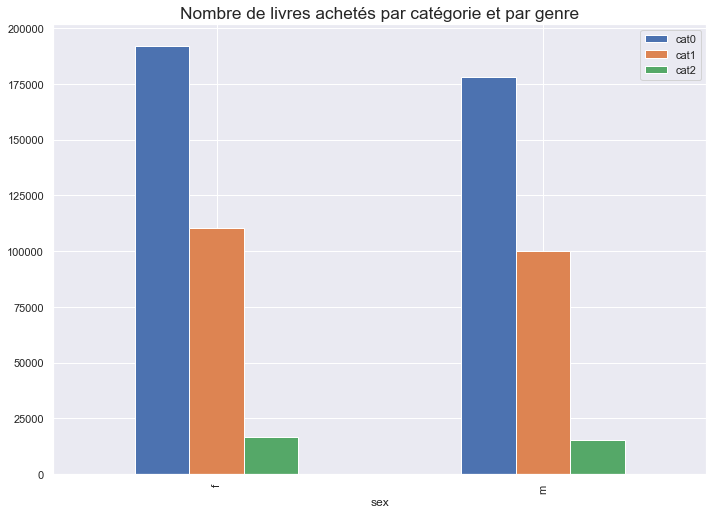

In [10]:
cont.loc[cont.index != "total",cont.columns !="total"].T.plot(kind = "bar", title = "Nombre de livres achetés par catégorie et par genre");

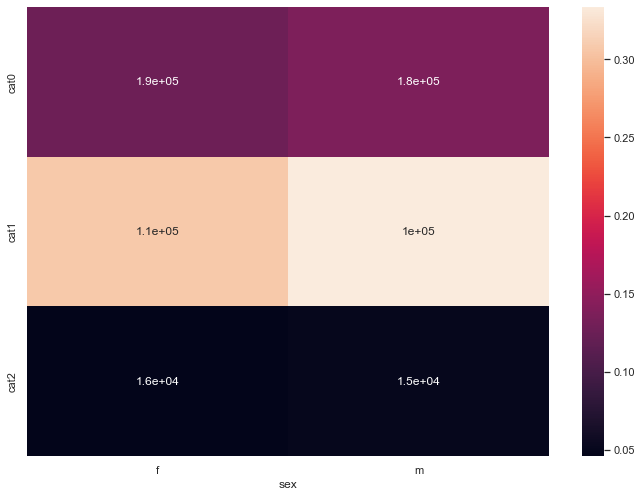

In [11]:
def heatmap(cont):
    """Seul paramètre: le tableau de contingence"""
    #Création du tableau de contingence attendu si indépendance
    tx = cont.loc[:,["total"]]
    ty = cont.loc[["total"],:]
    n = cont.loc["total", "total"]
    indep = tx.dot(ty) / n

    #Création de la heatmap
    measure = (cont-indep)**2/indep#On regarde l'écart entre la valeur constatée et la valeur attendue
    xi_n = measure.sum().sum()
    table = measure/xi_n#On normalise entre 0 et 1 les valeurs.
    sns.heatmap(table.iloc[:-1,:-1],annot=cont.iloc[:-1,:-1])
    plt.show()
heatmap(cont)

On remarque que les valeurs de la catégorie 1 s'écarte plus des valeurs attendues que les autres.<br>
Afin de vérifier la dépendance de 2 variables qualitatives, nous allons utiliser le test statistique du Chi-2.
# Test du chi2
Nous pouvons utiliser le test du $\chi^2$ afin de vérifier l'indépendance de deux variables. Les conditions de ce test, établie par Cochran sont:
- Les effectifs théoriques sont non nuls.
- 80% des effectifs théoriques sont supérieurs à 5.

Les hypothèses sont:<br> 
$H_0:$ Les variables sont indépendantes, il n'y a pas de relation entre elles<br>
$H_a:$ Les variables sont dépendantes, il existe une relation entre elles

Le test se calcule en comparant les différences entre $O_{ij}$(valeurs observées) et $E_{ij}$(valeurs attendues):
$$\chi^2 = \sum\frac{(O-E)^2}{E}\sim\chi^2_{(r-1)(c-1)}$$
r = nombre de lignes<br>
c = nombre de colonnes

In [12]:
def chi2_contingence(data, alpha=0.05, print_expected=False):
    """data = tableau de contingence. Attention, ne pas mettre les colonnes "total".
    alpha : risque d'erreur
    print_expected : Si True, affiche le tableau de contingence attendu."""
    chi2, p, dof, expected = st.chi2_contingency(data)
    if print_expected:
        print("fréquences attendues:")
        display(expected)
        
    print(f"degré de liberté: {dof}\n")
    
    print("En utilisant les valeurs critiques:")
    print(f"statistique du chi2: {chi2:.5g}")
    valeur_critique = st.chi2.ppf(1-alpha, dof)
    conclusion = f"statistique du chi2 <= {valeur_critique:.2f}:\nOn ne rejette pas l'hypothèse nulle à {alpha*100:.0f}%. Les deux variables sont indépendantes."
    if chi2 > valeur_critique:
        conclusion = f"statistique du chi2 > {valeur_critique:.2f}:\nOn rejette l'hypothèse nulle à {alpha*100:.0f}%. {color_blue}Les deux variables sont dépendantes.{color_reset}"
    print(conclusion)    
    print("\n--------------------------------------------------------------------------------------\n")
    print("En utilisant la p-value:")
    print(f"p-value: {p:.5g}")
    conclusion = f"p-value > {alpha}:\nOn ne rejette pas l'hypothèse nulle à {alpha*100:.0f}%. Les deux variables sont indépendantes."
    if p <= alpha:
        conclusion = f"p-value <= {alpha}:\nOn rejette l'hypothèse nulle à {alpha*100:.0f}%. {color_blue}Les deux variables sont dépendantes.{color_reset}"
    print(conclusion)
        
chi2_contingence(cont.iloc[:-1,:-1])

degré de liberté: 2

En utilisant les valeurs critiques:
statistique du chi2: 18.758
statistique du chi2 > 5.99:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------

En utilisant la p-value:
p-value: 8.4485e-05
p-value <= 0.05:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.


## <p style="text-indent:100px;"><a name="E4">B. En chiffre d'affaires</a></p>

In [13]:
cont = customer3[["sex", "CAcat0", "CAcat1", "CAcat2", "CA"]].groupby("sex").sum().T
cont["total"] = cont.sum(axis=1)
cont.rename(index={'CA':'total'}, inplace=True)
cont

sex,f,m,total
CAcat0,2.039641e+06,1.897159e+06,3.936800e+06
CAcat1,2.269302e+06,2.048239e+06,4.317541e+06
CAcat2,1.246912e+06,1.177122e+06,2.424034e+06
total,5.555855e+06,5.122520e+06,1.067838e+07


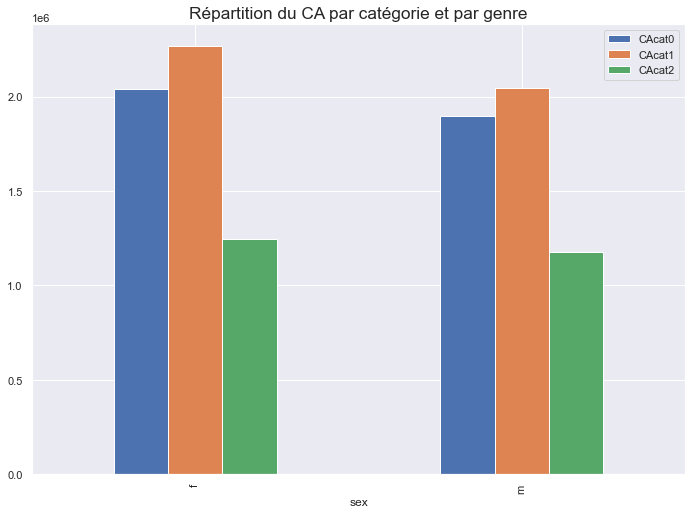

In [14]:
cont.loc[cont.index != "total",cont.columns != "total"].T.plot(kind = "bar", title = "Répartition du CA par catégorie et par genre");

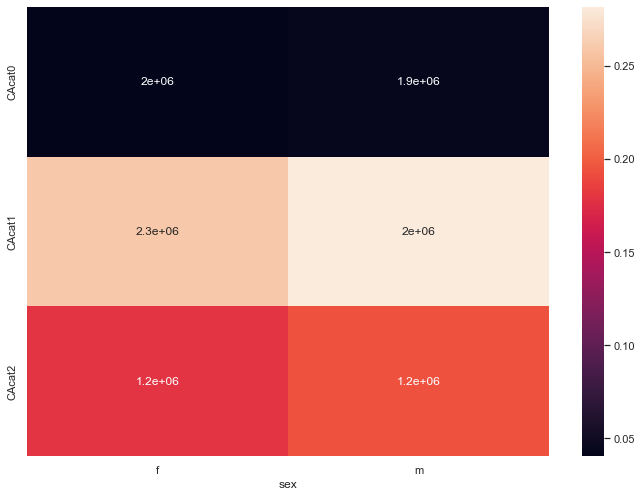

In [15]:
heatmap(cont)

In [16]:
chi2_contingence(cont.iloc[:-1,:-1])

degré de liberté: 2

En utilisant les valeurs critiques:
statistique du chi2: 901.23
statistique du chi2 > 5.99:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------

En utilisant la p-value:
p-value: 2.0016e-196
p-value <= 0.05:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.


## <p style="text-indent:50px;"><a name="D16">2 - Genre et montant total</a></p>


Nous sommes ici en présence d'une variable qualitative et d'une variable quantitave. Nous réaliserons donc une ANOVA pour regarder le lien entre les variables.
# ANOVA

Comme expliqué dans cet [article](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b), afin de mener une ANOVA, nous devons respecter certaines conditions:
<li>Les observations sont indépendantes:</li>
<dd style="text-indent:30px;">Pour respecter cette condition, nous allons tirer un échantillon aléatoire dans notre population.</dd>
<li>Chaque groupe a une distribution normale:</li>
<dd style="text-indent:30px;">Réalisation de Q-Q plot afin de vérifier la normalité à l'oeil ou utilisation du test de Shapiro-Wilk. Cette condition peut cependant être relâchée lorsque la population est assez grande(n>30).</dd>
<li>Tous les groupes ont une variance égale:</li>
<dd style="text-indent:30px;">Ratio du plus grand écart type sur le plus petit. Si le ratio est inférieur à 2, nous pouvons considérer l'homogénéité de la variance.</dd>
    
<br> Le principe de l'ANOVA est le suivant: <br>En spécifiant le modèle $$Y_{ik} = \mu + \alpha_i + \epsilon_{ik}$$
Nous allons regarder si les $\alpha_i$ sont identiques ou non. S'ils sont identiques, alors les deux variables sont indépendantes. <br>
Les hypothèses du test seront:    
$H_0:\alpha_0 = \alpha_1 = ... = \alpha_i$ (indépendance)<br>$H_a: \exists i,j$ tel que $\alpha_i \ne \alpha_j $<br>

$$F = \frac{MSTR}{MSE}\sim F_{(i-1)(n-i)}$$
<br>
*avec:*<br>
MSTR : La moyenne des carrés (somme des carrés divisés par le nombre de degrés de liberté) venue de la différence entre les groupes.<br>
MSE : La moyenne des carrés venue de la différence au sein des groupes.<br>
i : Nombre de groupes<br>
n : Nombre de données<br>

En cas de rejet de $H_0$, nous pouvons réaliser un test post-hoc afin de savoir d'où provient la dépendance (Quelles moyennes ne sont pas égales). Pour cela nous utiliserons le test de Tukey:

# Test de Tukey:
Le test de Tukey permet de faire des comparaisons multiples en une seule étape. Ce test a les mêmes conditions que l'ANOVA et sa statistique de test est:

$$Q_{i,j} = \frac{|M_i - M_j|}{\sqrt{\frac{MCR}{n}}}$$
*avec:*<br>
$M$ la moyenne du sous groupe,<br>
$MCR$ la moyenne des carrés résiduels.<br><br>
Ses hypothèses sont:<br>
$H_0: \alpha_i=\alpha_j$<br>
$H_1: \alpha_i\ne\alpha_j$<br>

A présent, voyons le test de Shapiro-Wilk qui nous permettra de vérifier la normalité des sous-échantillons.

# Test de Shapiro-Wilk
Le test de Shapiro-Wilk permet de tester l'adéquation à la loi normale<br>
$H_0: x\sim N$<br>
$H_a: x\not\sim N$

$$ W = \frac{(\sum_{i=1}^{n}a_ix_{(i)})^2}{\sum_i^n(x_i-\bar{x})^2}$$

Les valeurs seuils de la statistique W se trouvent dans la table de Shapiro-Wilk. 

In [17]:
def anova(donnee, x, y, tail_hypothesis_type = "two-tailed", alpha = 0.05):
    """x : qualitative
    y : quantitative
    tail possible types: right-tailed, left-tailed, two-tailed
    alpha : risque d'erreur pour l'interprétation"""
    # Create ANOVA backbone table
    data = [['Between Groups', '', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '', '']] 
    anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit', 'eta squared']) 
    anova_table.set_index('Source of Variation', inplace = True)

    # calculate SSTR and update anova table
    x_bar = donnee[y].mean()
    SSTR = donnee.groupby(x).count() * (donnee.groupby(x).mean() - x_bar)**2
    anova_table['SS']['Between Groups'] = SSTR[y].sum()

    # calculate SSE and update anova table
    SSE = (donnee.groupby(x).count() - 1) * donnee.groupby(x).std()**2
    anova_table['SS']['Within Groups'] = SSE[y].sum()

    # calculate SSTR and update anova table
    SSTR = SSTR[y].sum() + SSE[y].sum()
    anova_table['SS']['Total'] = SSTR

    # update degree of freedom
    anova_table['df']['Between Groups'] = donnee[x].nunique() - 1
    anova_table['df']['Within Groups'] = donnee.shape[0] - donnee[x].nunique()
    anova_table['df']['Total'] = donnee.shape[0] - 1

    # calculate MS
    anova_table['MS'] = anova_table['SS'] / anova_table['df']

    # calculate F 
    F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
    anova_table['F']['Between Groups'] = F

    # p-value
    anova_table['P-value']['Between Groups'] = 1 - st.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

    # F critical 
    
    if tail_hypothesis_type == "two-tailed":
        alpha /= 2
    anova_table['F crit']['Between Groups'] = st.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])
    
    if tail_hypothesis_type == "two-tailed":
        alpha *=2
    # eta squared
    anova_table['eta squared']['Between Groups'] = anova_table.loc["Between Groups", "SS"]/anova_table.loc["Total", "SS"]
    
    # Final ANOVA Table
    display(anova_table)
    interpretation_anova(anova_table, alpha)
    if anova_table['P-value']['Between Groups'] <= alpha:
        print(f"------------------------------------------------------------------\n\
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:\n\
{pairwise_tukeyhsd(donnee[y], donnee[x])}")
    return anova_table


def interpretation_anova(anova_table, alpha=0.05):
    """Fonction interprétant le résultat de l'ANOVA."""
    
    # Valeur critique
    print("En utilisant la valeur critique:")
    conclusion = f"F-score: {anova_table['F']['Between Groups']:.2f} <= {anova_table['F crit']['Between Groups']:.2f}:\n\
    On ne rejette pas H0 à {alpha*100:.0f}%. Les variables sont indépendantes."
    if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
        conclusion = f"F-score: {anova_table['F']['Between Groups']:.2f} > critical value: {anova_table['F crit']['Between Groups']:.2f}:\n\
        On rejette H0 à {alpha*100:.0f}%. {color_blue}Les deux variables sont dépendantes.{color_reset}"
    print(conclusion)
    print("\n--------------------------------------------------------------------------------------")
    # p-value
    print("En utilisant la p-value:")
    conclusion = f"p-value: {anova_table['P-value']['Between Groups']:.2f} > {alpha}:\n\
    On ne rejette pas H0 à {alpha*100:.0f}%. Les variables sont indépendantes."
    if anova_table['P-value']['Between Groups'] <= alpha:
        conclusion = f"p-value: {anova_table['P-value']['Between Groups']:.2f} <= {alpha}:\n\
        On rejette H0 à {alpha*100:.0f}%. {color_blue}Les deux variables sont dépendantes.{color_reset}"   
    print(conclusion)
    
    
def prep_anova(data, primary_key, x, y, nb_sample = 2000, seed = 15, alpha = 0.05, showflier = False):
    """data : DataFrame contenant les variables
    primary_key : Primary_key du DataFrame (n'ayant pas de doublons!)
    x : qualitative
    y : quantitative
    nb_sample : Nb de données tirées
    seed : Graine
    alpha : risque d'erreur
    showflier : Afficher les outliers dans le boxplot"""
    
    #Statistique des variables
    display(data[[x, y]].groupby(x).describe())
    
    #boxplot
    sns.boxplot(data=data,
                x=y, #On inverse x et y pour avoir le boxplot en horizontale.
                y=x,
                showmeans = True,
                meanprops = {"marker" : "o",
                             "markerfacecolor" : "white",
                             "markeredgecolor" : "black"},
                showfliers = showflier);
    plt.show()
    print("\n ------------------------------------------------------------\n")
    print("Création de l'échantillon:")
    
    # Création de l'échantillon
    random.seed(seed) # On fixe une "graine" afin d'obtenir tout le temps le même résultat
    sample_primary_key = random.sample(data[primary_key].to_list(), nb_sample)
    sample_data = data.loc[data[primary_key].isin(sample_primary_key)].reset_index(drop=True)

    # two variables of interest
    sample_data = sample_data[[x, y]]
    groups = sample_data.groupby(x).count().reset_index()
    groups.rename(columns={y : "nombre"}, inplace = True)
    print("Répartition dans chaque groupe:")
    display(groups)
    print("\nVérifions la normalité:")
    
    # Vérification de la normalité:
    unique_group = data[x].unique()
    if len(unique_group) == 2:
        i=121
    elif len(unique_group) > 2:
        i=221
        
    for group in unique_group:
        plt.subplot(i)
        st.probplot(sample_data.loc[sample_data[x] == group][y], dist="norm", plot=plt)
        plt.title("Probability Plot - " +  str(group))
        if i == 221 or i == 222:
            plt.xlabel("")    
        if i == 222 or i ==224:
            plt.ylabel("")
        i += 1
    plt.show()
    print("\n ------------------------------------------------------------\n")
    print("Test de Shapiro-Wilk:")
    for group in unique_group:
        print(f"     Groupe {group}:")
        p = st.shapiro(sample_data.loc[sample_data[x] == group][y]).pvalue
        conclusion = f"p-value = {p:.2f} < {alpha}: On rejette H0 à {alpha*100:.0f}%. Le groupe {group} ne suit pas une loi normale."
        if p >= alpha:
            conclusion = f"p-value = {p:.2f} >= {alpha}: On ne rejette pas H0 à {alpha*100:.0f}%. Le groupe {group} suit une loi normale."
                
        print(conclusion)
        
    print("\n ------------------------------------------------------------\n")
    print("Vérifions l'homogénéité de la variance:")
    # calculate ratio of the largest to the smallest sample standard deviation
    ratio = sample_data.groupby(x).std().max() / sample_data.groupby(x).std().min()
    conclusion = "Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA."
    if ratio[0] > 2:
        conclusion = "Il est supérieur à 2. Nous ne pouvons pas réaliser l'ANOVA."
    print(f"\nLe ratio vaut {ratio[0]:.2f}. {conclusion}")
    
    return sample_data

CA                                                                 \
      count         mean         std    min       25%       50%        75%   
sex                                                                          
f    4476.0  1241.254376  925.615569  13.36  535.7925  1002.085  1731.0525   
m    4118.0  1243.934052  936.884225   8.30  530.7375   998.540  1725.5025   

                  
             max  
sex               
f    5214.050000  
m    4981.142795

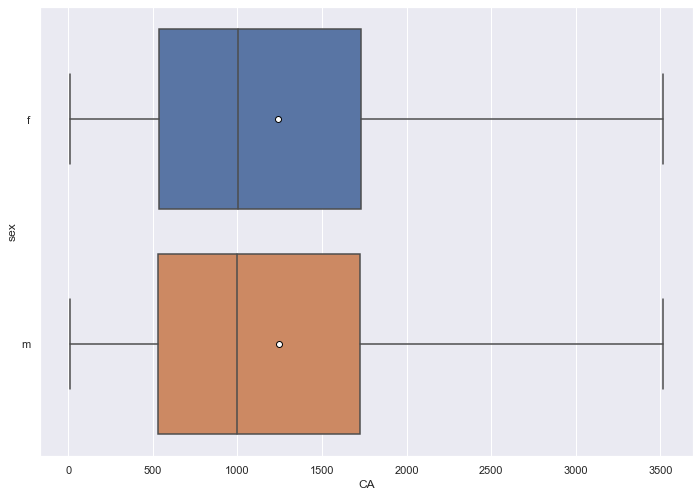


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,sex,nombre
0,f,1057
1,m,943



Vérifions la normalité:


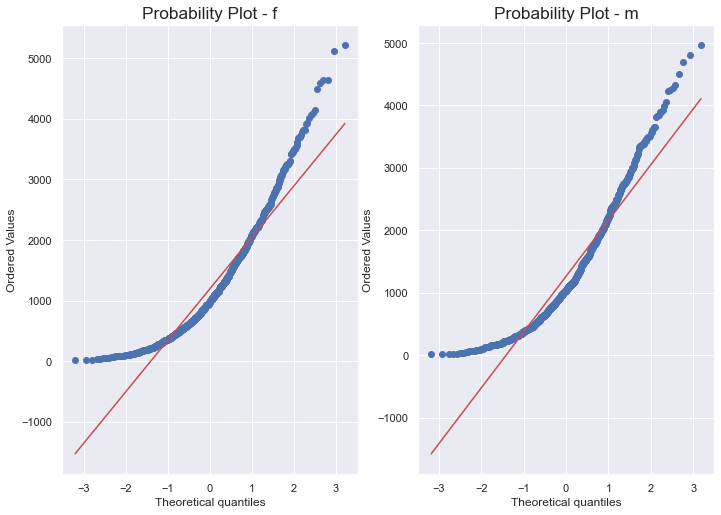


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe f:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe f ne suit pas une loi normale.
     Groupe m:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe m ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.05. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [18]:
sample = prep_anova(customer3, "client_id", "sex", "CA")

Comme nous pouvions le voir sur le Q-Q plot, les groupes ne suivent pas une loi normale. Cependant, comme nous l'avons vu, nous pouvons outrepasser la condition de la normalité. Etant donné que la condition de l'homogénéité de la variance est respectée, nous pouvons calculer notre ANOVA.

In [19]:
anova_table = anova(sample, "sex", "CA")

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,2221154.998271,1,2221154.998271,2.693092,0.100941,5.031468,0.001346
Within Groups,1647871044.839512,1998,824760.282702,,,,
Total,1650092199.837783,1999,825458.829334,,,,


En utilisant la valeur critique:
F-score: 2.69 <= 5.03:
    On ne rejette pas H0 à 5%. Les variables sont indépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.10 > 0.05:
    On ne rejette pas H0 à 5%. Les variables sont indépendantes.


Il n'y a pas de relation entre le genre et le montant total dépensé. Regardons maintenant la relation entre l'âge et le montant total.<br> Pour chaque analyse avec l'âge, nous analyserons l'âge en temps que variable continue puis avec les 2 groupes l'un après l'autre.<br>
Pour rappel,<br> le premier groupe: (-30, 30-50, 50-70, 70+).<br> Le second groupe:(-30, 30-65, 65+)

## <p style="text-indent:50px;"><a name="D17">3 - Age et montant total</a></p>
Pour réaliser l'analyse entre 2 variables numériques, nous allons utiliser la corrélation de Spearman.
# Corrélation de Spearman
Contrairement à la corrélation de Pearson qui ne teste qu'une relation de corrélation linéaire, le test de Spearman teste une relation de corrélation monotone. Pour cela, il n'utilise pas la covariance entre les variables mais la covariance entre leurs rangs. De plus, celui-ci n'a pas besoin que les données soient distribuées normalement. Cela sera donc bien mieux pour nous. La corrélation de Spearman se calcule:
$$\rho= 1 -\frac{6\sum_{i=1}^nd_i^2}{n^3-n}$$
*avec:*<br>
$d_i$ la différence entre le rang de l'observation $i$ et celui de sa valeur.<br>
$n$ le nombre d'observations.<br>

Une fois que nous avons calculé ce coefficient, nous pouvons nous demander si celui-ci est significativement différent de 0 ou non. Pour ce faire nous allons utiliser un test de student avec une statistique de test modifiée:<br>
Hypothèse:<br>
$H_0: \rho = 0$<br>
$H_a: \rho \ne 0$<br>
La statistique de test est la suivante:
$$t = \rho\sqrt{\frac{n-2}{1-\rho}}\sim T_{n-2}$$
Dans la pratique, nous utiliserons la p-value fournie par la librairie scipy afin de tester nos hypothèses.

In [20]:
def spearman(data, x, y, alpha = 0.05):
    """Imprime le coefficient de corrélation ainsi que la p-value associée avec son interprétation."""
    rho, p = st.spearmanr(data[x], data[y])
    print(f"Le coefficient de Spearman vaut {rho:.2f}.")
    conclusion = f"La p-value associée au coefficient vaut {p:.2f} > {alpha}. On ne rejette pas H0 à {alpha*100:.0f}%.\n\
Le coefficient de corrélation de Spearman n'est pas significativement différent de 0."
    if p <= alpha:
        conclusion = f"La p-value associée au coefficient vaut {p:.2f} <= {alpha}. On rejette H0 à {alpha*100:.0f}%.\n\
{color_blue}Le coefficient de corrélation de Spearman est significativement différent de 0.{color_reset}"
    print(conclusion)

In [21]:
spearman(customer3, "age", "CA")

Le coefficient de Spearman vaut -0.18.
La p-value associée au coefficient vaut 0.00 <= 0.05. On rejette H0 à 5%.
Le coefficient de corrélation de Spearman est significativement différent de 0.


## <p style="text-indent:100px;">A. Groupe 1</p>

CA                                                       \
           count         mean          std    min       25%       50%   
group                                                                   
(18, 30]  2080.0  1296.887675   912.859339  11.06  603.4375  1094.710   
(30, 50]  3409.0  1487.944301  1047.803275  15.72  666.7500  1203.460   
(50, 70]  2456.0   956.373227   702.703789   8.30  407.8200   774.905   
(70, 94]   649.0   862.240189   627.279639  12.99  367.1100   700.250   

                             
               75%      max  
group                        
(18, 30]  1806.565  5214.05  
(30, 50]  2097.560  5136.14  
(50, 70]  1352.655  4769.15  
(70, 94]  1203.530  3446.48

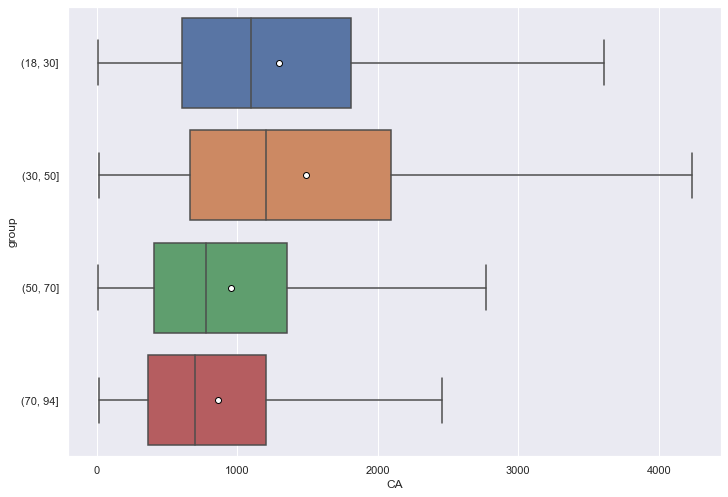


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group,nombre
0,"(18, 30]",509
1,"(30, 50]",745
2,"(50, 70]",601
3,"(70, 94]",145



Vérifions la normalité:


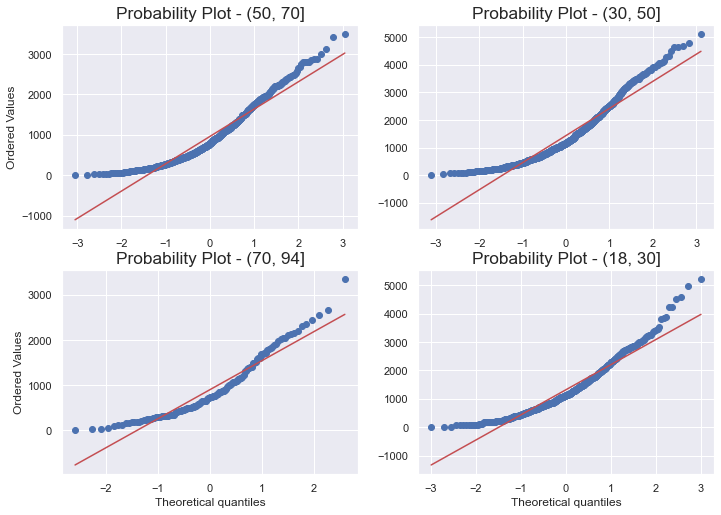


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (50, 70]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (50, 70] ne suit pas une loi normale.
     Groupe (30, 50]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 50] ne suit pas une loi normale.
     Groupe (70, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (70, 94] ne suit pas une loi normale.
     Groupe (18, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (18, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.53. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [22]:
sample = prep_anova(customer3, "client_id", "group", "CA")

In [23]:
anova_table = anova(sample, 'group', 'CA')

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,95572953.967318,3,31857651.322439,40.905169,0.0,3.12266,0.05792
Within Groups,1554519245.870464,1996,778817.25745,,,,
Total,1650092199.837782,1999,825458.829334,,,,


En utilisant la valeur critique:
F-score: 40.91 > critical value: 3.12:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.
------------------------------------------------------------------
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------
(18, 30] (30, 50]  114.9778 0.1065  -15.5085  245.4641  False
(18, 30] (50, 70]  -360.745    0.0 -497.4292 -224.0607   True
(18, 30] (70, 94] -423.9719    0.0 -637.5709  -210.373   True
(30, 50] (50, 70] -475.7228   -0.0 -600.1342 -351.3113   True
(30, 50] (70, 94] -538.9497    0.0 -744.9112 -332.9882   True
(50, 70] (70, 94]  -

On remarque que les moyennes entre les groupes "(50, 70]" et "(70, 94]" et entre "(18, 30]" et "(30, 50]" ne sont pas significativement différentes l'une de l'autre. Nous pouvons calculer la "fiabilité" du modèle sur l'ensemble du jeu de données.

In [24]:
def eta_squared(x,y):
    """x : qualitative
    y : quantitative"""
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [25]:
eta_squared(customer3.group, customer3.CA)

0.06799829380384338

La relation entre les variables existent mais celle-ci n'explique que très peu le montant total dépensé. 

## <p style="text-indent:100px;">B. Groupe 2</p>

CA                                                         \
           count         mean         std    min       25%          50%   
group2                                                                    
(18, 30]  2080.0  1296.887675  912.859339  11.06  603.4375  1094.710000   
(30, 65]  5349.0  1298.608926  975.030458   8.30  553.0000  1032.928384   
(65, 94]  1165.0   888.059662  629.784191  12.99  380.0600   737.890000   

                             
               75%      max  
group2                       
(18, 30]  1806.565  5214.05  
(30, 65]  1815.500  5136.14  
(65, 94]  1279.510  3446.48

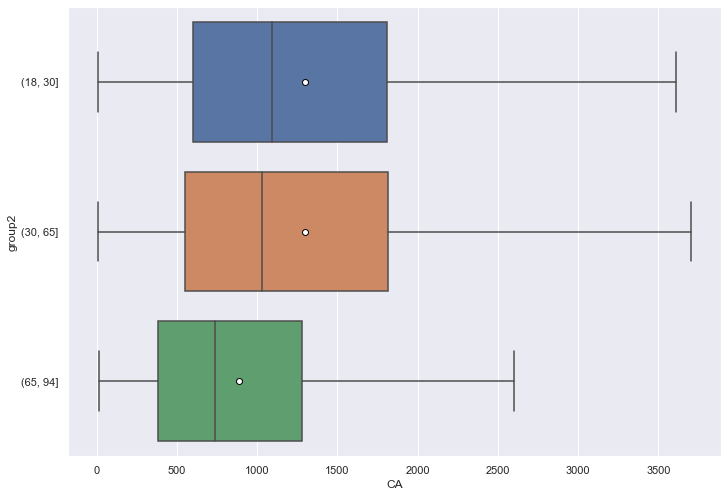


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group2,nombre
0,"(18, 30]",509
1,"(30, 65]",1222
2,"(65, 94]",269



Vérifions la normalité:


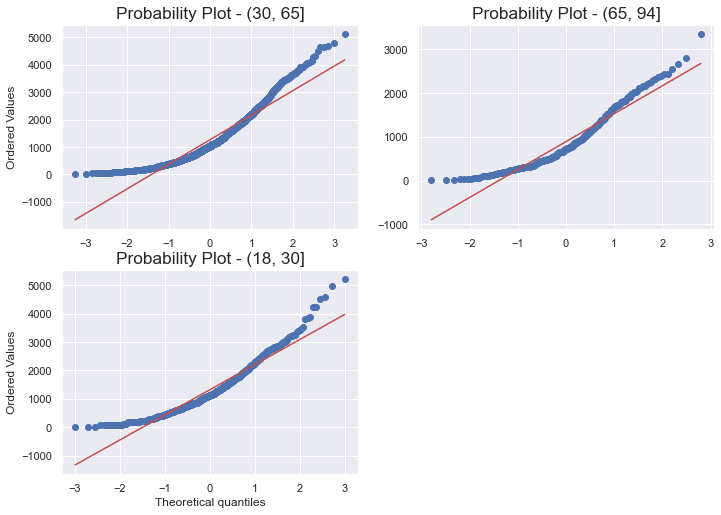


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (30, 65]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 65] ne suit pas une loi normale.
     Groupe (65, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (65, 94] ne suit pas une loi normale.
     Groupe (18, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (18, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.42. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [26]:
sample = prep_anova(customer3, "client_id", "group2", "CA")

In [27]:
anova_table = anova(sample, 'group2', 'CA')

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,36733410.187053,2,18366705.093526,22.734131,0.0,3.695702,0.022261
Within Groups,1613358789.65073,1997,807891.231673,,,,
Total,1650092199.837782,1999,825458.829334,,,,


En utilisant la valeur critique:
F-score: 22.73 > critical value: 3.70:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.
------------------------------------------------------------------
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------
(18, 30] (30, 65]  -62.1975 0.3888  -173.411   49.0159  False
(18, 30] (65, 94] -433.5309    0.0 -592.4434 -274.6185   True
(30, 65] (65, 94] -371.3334    0.0 -513.3144 -229.3524   True
-------------------------------------------------------------


In [28]:
eta_squared(customer3.group2, customer3.CA)

0.022738308417557366

Nous pouvons à présent regarder le lien entre l'âge et la fréquence d'achat.
## <p style="text-indent:50px;"><a name="D18">4 - Age et fréquence</a></p>
Notre calcul de la fréquence ne prendra pas en compte si l'utilisateur fait plusieurs achats le même jour avec des sessions différentes.<br>
Nous calculons la fréquence comme la moyenne du nombre de jours entre chaque session d'achat.

In [29]:
for name, group in m_product_transaction[["client_id", "fdate"]].groupby(by = ["client_id"]):
    group.sort_values(by = "fdate", inplace = True)#On trie pour avoir les dates dans l'ordre
    group.drop_duplicates(inplace=True)#Si plusieurs achat fait le même jour, pas pris en compte
    group.fdate = pd.to_datetime(group.fdate)
    freq = group.fdate.diff()[1:]#On ne récupère pas la première valeur qui est un NaN
    if len(freq) != 0:
        customer3.loc[customer3.client_id == name, "freq"] = freq.sum()/len(freq)#On prend la moyenne des fréquences.

customer3["freq"] /= pd.Timedelta(days=1)

Vérifions que la fréquence soit renseignée pour chaque client.

In [30]:
customer3.loc[customer3.freq.isna()].client_id.shape

(27,)

Cela s'explique par le fait que ces clients ont fait un seul et unique achat sur la boutique en ligne. Nous ne les prendrons pas en compte dans l'analyse.

In [31]:
spearman(customer3.loc[~customer3.freq.isna()], "age", "freq")

Le coefficient de Spearman vaut -0.21.
La p-value associée au coefficient vaut 0.00 <= 0.05. On rejette H0 à 5%.
Le coefficient de corrélation de Spearman est significativement différent de 0.


## <p style="text-indent:100px;">A. Groupe 1</p>

freq                                                         \
           count       mean        std        min        25%        50%   
group                                                                     
(18, 30]  2067.0  57.023884  53.086593  10.640625  27.510833  41.437500   
(30, 50]  3401.0  28.210581  28.313202   5.021127  10.984127  19.852941   
(50, 70]  2451.0  34.896959  37.124605   4.693333  13.240823  24.392857   
(70, 94]   648.0  37.584983  38.048900   5.458647  13.994792  26.058462   

                            
                75%    max  
group                       
(18, 30]  67.746032  548.0  
(30, 50]  34.894737  518.0  
(50, 70]  43.400000  549.0  
(70, 94]  45.962500  365.0

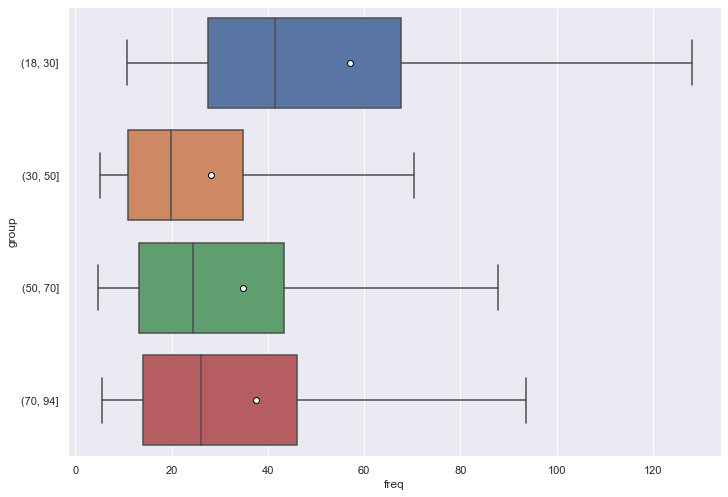


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group,nombre
0,"(18, 30]",468
1,"(30, 50]",791
2,"(50, 70]",587
3,"(70, 94]",154



Vérifions la normalité:


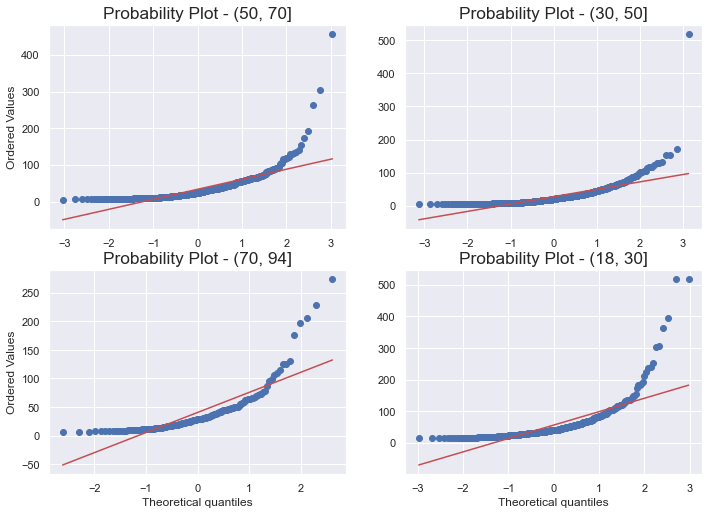


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (50, 70]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (50, 70] ne suit pas une loi normale.
     Groupe (30, 50]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 50] ne suit pas une loi normale.
     Groupe (70, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (70, 94] ne suit pas une loi normale.
     Groupe (18, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (18, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.90. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [32]:
sample = prep_anova(customer3.loc[~customer3.freq.isna()], "client_id", "group", "freq")

In [33]:
anova_table = anova(sample, "group", "freq")

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,248413.537386,3,82804.512462,54.116159,0.0,3.12266,0.075219
Within Groups,3054130.409748,1996,1530.125456,,,,
Total,3302543.947133,1999,1652.098023,,,,


En utilisant la valeur critique:
F-score: 54.12 > critical value: 3.12:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.
------------------------------------------------------------------
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
(18, 30] (30, 50] -28.3527   -0.0 -34.2182 -22.4873   True
(18, 30] (50, 70] -22.8433   -0.0 -29.0761 -16.6105   True
(18, 30] (70, 94] -15.7394 0.0001  -25.083  -6.3959   True
(30, 50] (50, 70]   5.5095 0.0481   0.0303  10.9886   True
(30, 50] (70, 94]  12.6133 0.0015   3.7547  21.4719   True
(50, 70] (70, 94]   7.1038 0.1861  -2.0022  

## <p style="text-indent:100px;">B. Groupe 2</p>

freq                                                         \
           count       mean        std        min        25%        50%   
group2                                                                    
(18, 30]  2067.0  57.023884  53.086593  10.640625  27.510833  41.437500   
(30, 65]  5338.0  30.661188  32.480569   4.693333  11.755090  21.176471   
(65, 94]  1162.0  36.284235  35.548802   5.458647  13.744194  26.057037   

                            
                75%    max  
group2                      
(18, 30]  67.746032  548.0  
(30, 65]  37.736842  549.0  
(65, 94]  44.615476  365.0

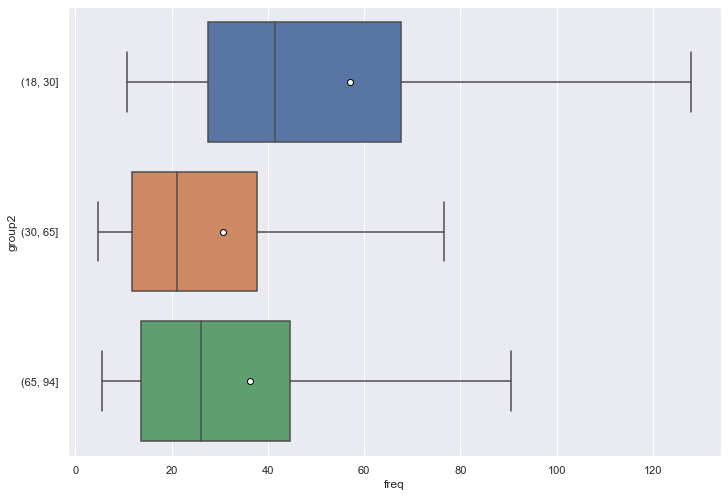


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group2,nombre
0,"(18, 30]",468
1,"(30, 65]",1251
2,"(65, 94]",281



Vérifions la normalité:


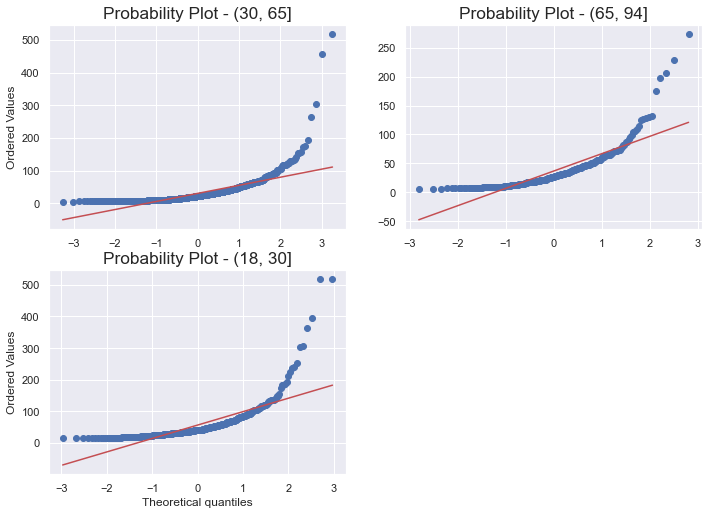


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (30, 65]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 65] ne suit pas une loi normale.
     Groupe (65, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (65, 94] ne suit pas une loi normale.
     Groupe (18, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (18, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.70. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [34]:
sample = prep_anova(customer3.loc[~customer3.freq.isna()], "client_id", "group2", "freq")

In [35]:
anova_table = anova(sample, "group2", "freq")

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,233904.415977,2,116952.207989,76.109806,0.0,3.695702,0.070826
Within Groups,3068639.531156,1997,1536.624703,,,,
Total,3302543.947133,1999,1652.098023,,,,


En utilisant la valeur critique:
F-score: 76.11 > critical value: 3.70:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.
------------------------------------------------------------------
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
(18, 30] (30, 65] -26.2038    0.0 -31.1857 -21.2219   True
(18, 30] (65, 94]  -19.498    0.0 -26.4366 -12.5593   True
(30, 65] (65, 94]   6.7059 0.0261   0.6363  12.7754   True
----------------------------------------------------------


## <p style="text-indent:50px;"><a name="D19">5 - Age et panier moyen</a></p>

In [36]:
#On récupère le nombre de sessions pour chaque client
customer3["panier_moyen"] = customer3["client_id"].map(
    m_product_transaction.merge(customer3, on = "client_id")[["client_id", "session_id"]].groupby(
        by = "client_id").count().to_dict()["session_id"])

#On divise le total dépensé sur le site par le nombre de sessions:
customer3["panier_moyen"] = customer3["CA"]/customer3["panier_moyen"]

In [37]:
spearman(customer3, "age", "panier_moyen")

Le coefficient de Spearman vaut -0.32.
La p-value associée au coefficient vaut 0.00 <= 0.05. On rejette H0 à 5%.
Le coefficient de corrélation de Spearman est significativement différent de 0.


## <p style="text-indent:100px;">A. Groupe 1</p>

panier_moyen                                                        \
                count       mean        std       min        25%        50%   
group                                                                         
(18, 30]       2080.0  40.519593  17.199317  4.410000  28.448185  38.961222   
(30, 50]       3409.0  14.433610   7.513789  2.993636  11.949065  12.838324   
(50, 70]       2456.0  16.166968   3.220105  4.150000  14.456594  16.065394   
(70, 94]        649.0  16.272258   2.938790  6.490000  14.729429  16.247609   

                              
                75%      max  
group                         
(18, 30]  49.825565  181.990  
(30, 50]  13.982447  100.990  
(50, 70]  17.628775   62.250  
(70, 94]  17.726984   39.464

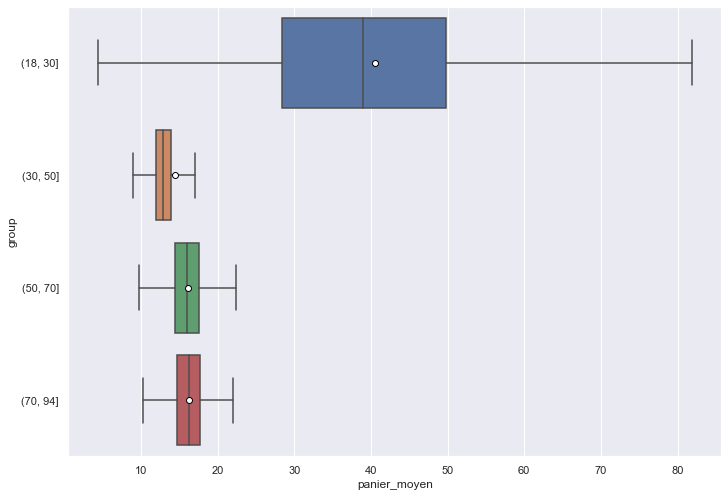


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group,nombre
0,"(18, 30]",509
1,"(30, 50]",745
2,"(50, 70]",601
3,"(70, 94]",145



Vérifions la normalité:


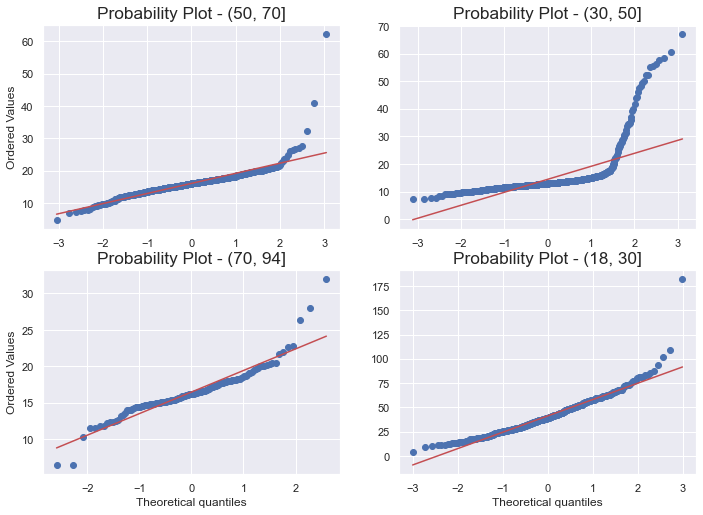


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (50, 70]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (50, 70] ne suit pas une loi normale.
     Groupe (30, 50]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 50] ne suit pas une loi normale.
     Groupe (70, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (70, 94] ne suit pas une loi normale.
     Groupe (18, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (18, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 5.62. Il est supérieur à 2. Nous ne pouvons pas réaliser l'ANOVA.


In [38]:
sample = prep_anova(customer3, "client_id", "group", "panier_moyen")

Nous pouvons vérifier la non homogénéité de la variance en réalisant un test de Levene:<br>
# Test de Levene
Le test de Levene permet de tester l'homogénéité de la variance.<br>
$H_0: \sigma_1 = \sigma_2 = ... = \sigma_i$<br>
$H_a: \sigma_i \ne \sigma_j$<br>
La statistique de test est:<br>
$$W = \frac{N - k}{k - 1}\frac{\sum_{i=1}^kN_i(\bar{Z_i} - \bar{Z})^2}{\sum_{i=1}^k\sum_{j=1}^{N_i}(Z_{ij} - \bar{Z_i})^2}\sim F_{\alpha,k-1,N-k}$$
*avec:*<br>
N la taille de l'échantillon de la variable testée (Y) divisée en k sous groupe où $N_i$ est la taille du sous groupe.<br>
$Z_{ij} = |Y_{ij} - \bar{Y_i}|$<br>
$\bar{Z_i}$ sont les moyennes des groupes $Z_{ij}$<br>
$\bar{Z}$ la moyenne globale de $Z_{ij}$

In [39]:
res = stat()
res.levene(df=sample, res_var='panier_moyen', xfac_var='group')
res.levene_summary

,Parameter,Value
0,Test statistics (W),276.2296
1,Degrees of freedom (Df),3.0000
2,p value,0.0000


La p-value est inférieure à 5%. On rejette donc l'hypothèse nulle ce qui confirme la non homogénéité de la variance. Nous ne pouvons appliquer l'ANOVA.<br>
A la place nous allons utiliser le test non paramétrique de Kruskal-Wallis:
# Kruskal-Wallis:
Le test de Kruskal-Wallis est la version non paramétrique de l'ANOVA, nous pouvons alors l'utiliser quand l'homogénéité de la variance n'est pas respectée.
Pour calculer la statistique de test, les sous échantillons $E_i$ de taille $n_i$ doivent être triés dans l'ordre croissant.
<br>*Statistique de test:*
$$h = \frac{12}{n(n+1)}(\sum_{i=1}^k\frac{r_i^2}{n_i})-3(n+1)$$
*avec:*<br>
$n$ l'effectif global,<br>
$r_i$ la somme cummulée.<br><br>
**Hypothèses:**<br><br>
$H_0: \alpha_1=...=\alpha_k$<br>
$H_a: \exists i,j$ tel que $\alpha_i \ne \alpha_j $<br>

Comme pour une ANOVA classique, nous pouvons réaliser un test post hoc en cas de rejet de $H_0$. Nous utiliserons cette fois le test de Nemenyi:

# Test de Nemenyi:
Le test de Nemenyi est un test non paramétrique. Il s'apparente au test de Tukey mais il teste la différence entre les moyennes des rangs des groupes.<br>
Ses hypothèses sont:<br>
$H_0: \alpha_i=\alpha_j$<br>
$H_1: \alpha_i\ne\alpha_j$<br>

*Statistique de test:*<br>
$$\chi^2=\frac{(\bar{r_i}-\bar{r_j})^2}{\frac{n(n+1)}{12}(\frac{1}{n_i}+\frac{1}{n_j})C}$$
*avec:*<br>
$r_i, r_j$ Les moyennes des rangs des groupes i,j.<br>
$n$ le nombre total d'observations<br>
$n_i, n_j$ le nombre total d'observations dans les sous groupes<br>
$C$ un facteur de corrélation ($C = 1 - \frac{\sum_{i=1}^K(t_i^3-t_i)}{(n^3-n)}$)

In [40]:
def kw(data, x, y, alpha = 0.05):
    """Cette fonction renvoie la P-value du test de Kruskal-Wallis.
    data = DataFrame
    x = qualitative
    y = quantitative"""
    p = st.stats.kruskal(*[i for j,i in data.groupby(x)[y]]).pvalue
    
    conclusion = f"p-value: {p:.2f} > {alpha}:\n\
    On ne rejette pas H0 à {alpha*100:.0f}%. Les variables sont indépendantes."
    if p <= alpha:
        conclusion = f"p-value: {p:.2f} <= {alpha}:\n\
        On rejette H0 à {alpha*100:.0f}%. {color_blue}Les deux variables sont dépendantes.{color_reset}"   
    print(conclusion)
    
    if p <= alpha:
        print("\n Réalisons un test de Nemenyi afin de voir quelles moyennes ne sont pas égales.")
        nemenyi(data, x, y, alpha)
    
def nemenyi(data, x, y, alpha):
    """Cette fonction renvoie la P-value du test de Nemenyi.
    data = DataFrame
    x = qualitative
    y = quantitative"""
    
    p = sp.posthoc_nemenyi(data, val_col = y, group_col = x)
    
    z = 1
    for i in p.columns:
        for j in range(z, len(p)):
            print("\n------------------------------------------------------\n")
            conclusion = f"Pour {i} - {p.index[j]}:\n\
p-value = {p.loc[p.index[j], i]:.2f} < {alpha*100:.0f}%. On rejette H0 à {alpha*100:.0f}%. Les deux moyennes sont \
significativement différentes.\n{color_blue}La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.{color_reset}"
            if p.loc[p.index[j], i] > alpha:
                conclusion = f"Pour {i} - {p.index[j]}:\n\
p-value = {p.loc[p.index[j], i]:.2f} > {alpha*100:.0f}%. On ne rejette pas H0 à {alpha*100:.0f}%.\
Les deux moyennes ne sont pas significativement différentes.\n\
La dépendance de nos deux variables ne s'expliquent pas à travers ces 2 groupes."
            print(conclusion)
        z += 1

In [41]:
kw(sample, "group", "panier_moyen")

p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

 Réalisons un test de Nemenyi afin de voir quelles moyennes ne sont pas égales.

------------------------------------------------------

Pour (18, 30] - (30, 50]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

------------------------------------------------------

Pour (18, 30] - (50, 70]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

------------------------------------------------------

Pour (18, 30] - (70, 94]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

--------------------------------------------

## <p style="text-indent:100px;">B. Groupe 2</p>

panier_moyen                                                        \
                count       mean        std       min        25%        50%   
group2                                                                        
(18, 30]       2080.0  40.519593  17.199317  4.410000  28.448185  38.961222   
(30, 65]       5349.0  15.021047   6.330157  2.993636  12.285217  13.623516   
(65, 94]       1165.0  16.414905   3.252416  6.490000  14.753000  16.251733   

                             
                75%     max  
group2                       
(18, 30]  49.825565  181.99  
(30, 65]  15.923667  100.99  
(65, 94]  17.752500   62.25

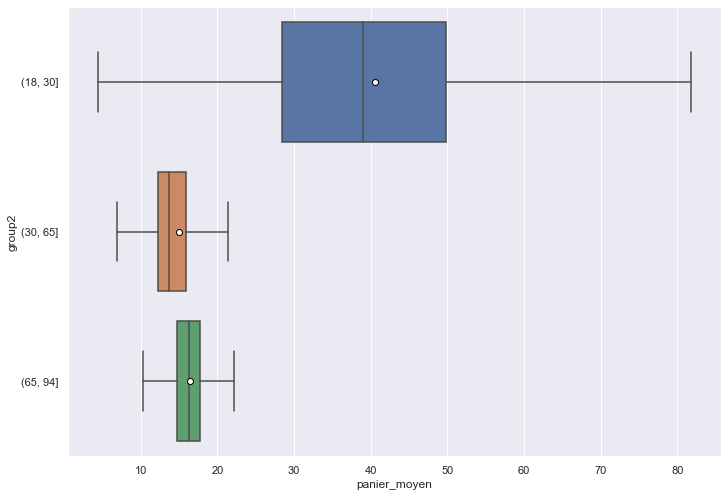


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group2,nombre
0,"(18, 30]",509
1,"(30, 65]",1222
2,"(65, 94]",269



Vérifions la normalité:


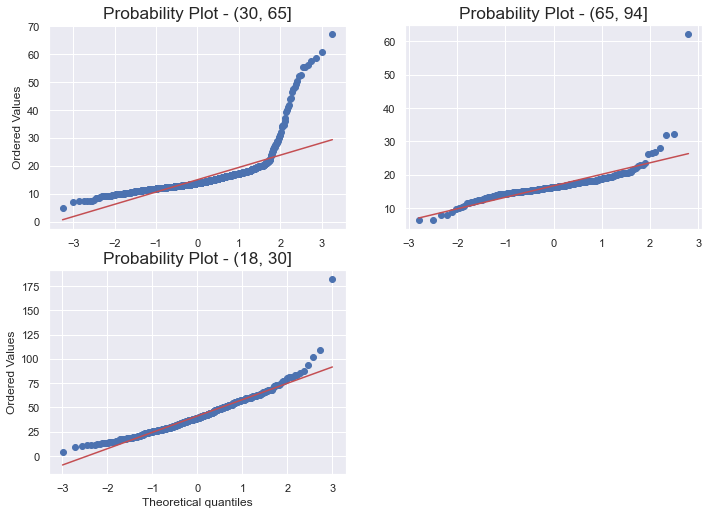


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (30, 65]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 65] ne suit pas une loi normale.
     Groupe (65, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (65, 94] ne suit pas une loi normale.
     Groupe (18, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (18, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 4.12. Il est supérieur à 2. Nous ne pouvons pas réaliser l'ANOVA.


In [42]:
sample = prep_anova(customer3, "client_id", "group2", "panier_moyen")

In [43]:
res.levene(df=sample, res_var='panier_moyen', xfac_var='group2')
res.levene_summary

,Parameter,Value
0,Test statistics (W),395.6966
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


La p-value est inférieure à 5%. On rejette donc l'hypothèse nulle ce qui confirme la non homogénéité de la variance. Nous ne pouvons appliquer l'ANOVA. Appliquons le test de Kruskal-Wallis.

In [44]:
kw(sample, "group2", "panier_moyen")

p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

 Réalisons un test de Nemenyi afin de voir quelles moyennes ne sont pas égales.

------------------------------------------------------

Pour (18, 30] - (30, 65]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

------------------------------------------------------

Pour (18, 30] - (65, 94]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

------------------------------------------------------

Pour (30, 65] - (65, 94]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.


## <p style="text-indent:50px;"><a name="D20">6 - Age et catégorie</a></p>

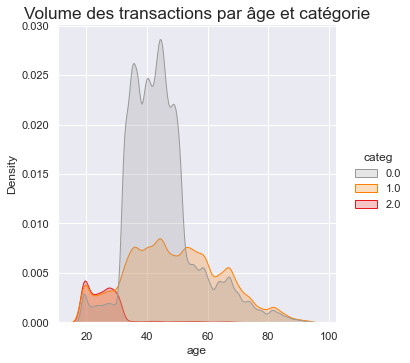

In [45]:
sns.displot(data=m_product_transaction.merge(customer3), x='age', hue='categ', kind='kde', fill = True, palette = "Set1_r")
plt.title('Volume des transactions par âge et catégorie');

## <p style="text-indent:100px;">A. Groupe 1</p>

In [46]:
df = m_product_transaction.merge(customer3[["sex","birth", "group", "group2", "client_id"]], on = "client_id")
df = df.loc[~df.date.astype(str).str.startswith("2021-10")] #On supprime les données d'octobre
cont = df[["categ", "group"]].pivot_table(index = "categ", columns = "group", aggfunc = len, margins = True, margins_name = "total")
cont

group,"(18, 30]","(30, 50]","(50, 70]","(70, 94]",total
categ,,,,,
0.0,14728,275718,65491,14132,370069
1.0,25669,90519,75618,18971,210777
2.0,26645,3634,1212,289,31780
total,67042,369871,142321,33392,612626


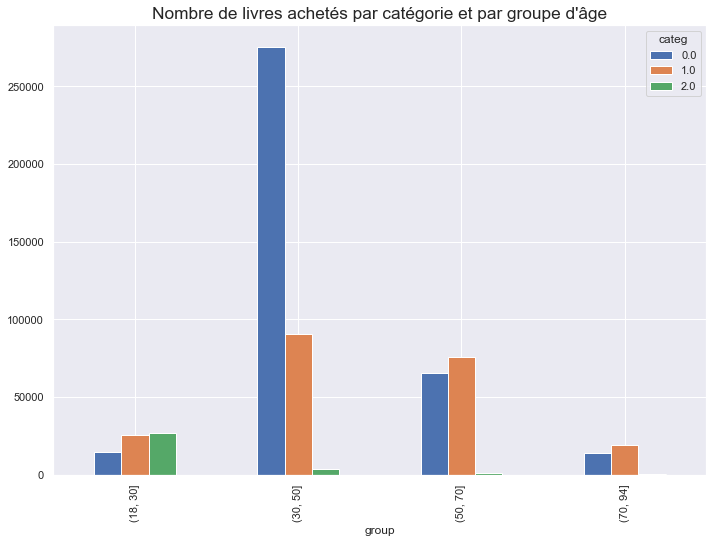

In [47]:
cont.loc[cont.index != "total",cont.columns != "total"].T.plot(kind = "bar", title = "Nombre de livres achetés par catégorie et par groupe d'âge");

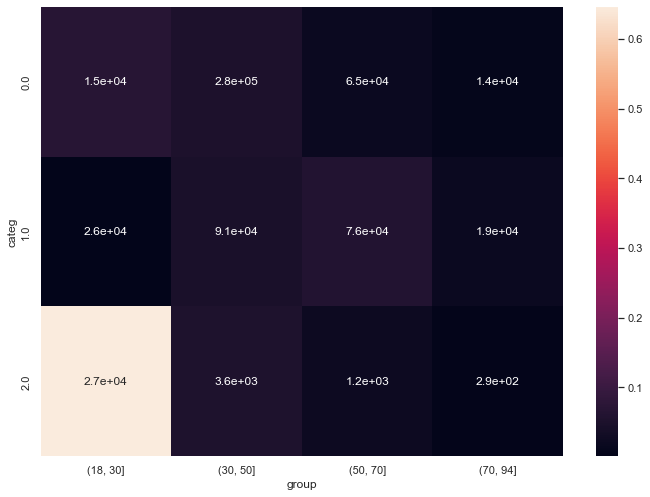

In [48]:
heatmap(cont)

In [49]:
chi2_contingence(cont.iloc[:-1,:-1])

degré de liberté: 6

En utilisant les valeurs critiques:
statistique du chi2: 2.389e+05
statistique du chi2 > 12.59:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------

En utilisant la p-value:
p-value: 0
p-value <= 0.05:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.


## <p style="text-indent:100px;">B. Groupe 2</p>

In [50]:
cont = df[["categ", "group2"]].pivot_table(index = "categ", columns = "group2",
                                           aggfunc = len, margins = True, margins_name = "total")
cont

group2,"(18, 30]","(30, 65]","(65, 94]",total
categ,,,,
0.0,14728,329405,25936,370069
1.0,25669,150191,34917,210777
2.0,26645,4575,560,31780
total,67042,484171,61413,612626


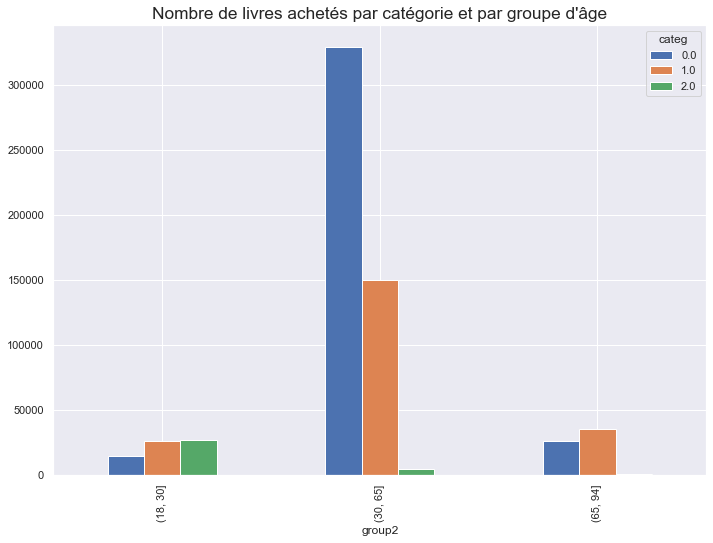

In [51]:
cont.loc[cont.index != "total",cont.columns != "total"].T.plot(kind = "bar", title = "Nombre de livres achetés par catégorie et par groupe d'âge");

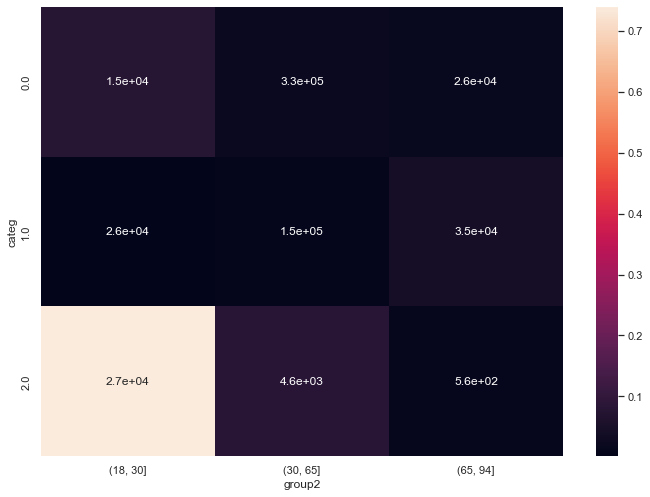

In [52]:
heatmap(cont)

In [53]:
chi2_contingence(cont.iloc[:-1,:-1])

degré de liberté: 4

En utilisant les valeurs critiques:
statistique du chi2: 2.0861e+05
statistique du chi2 > 9.49:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------

En utilisant la p-value:
p-value: 0
p-value <= 0.05:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.


---------------------------------------------------------------------------------------<br>Nous avons analysé les données pour les clients avec leur âge actuel et pas au moment de l'achat. Cela signifie qu'il y aurait un effet générationnel plutôt qu'un effet lié à l'âge( passer d'étudiant à adulte...). Nous allons donc reconduire nos analyses en prenant en compte l'âge au moment de l'achat et non l'âge aujourd'hui.

## <p style="text-indent:50px;"><a name="D21">7 - Analyse en prenant en compte l'age au moment de l'achat</a></p>

In [54]:
df.drop(columns=["group", "group2"], inplace=True) #On supprime les colonnes de groupe d'âge

df.fdate = df.date.dt.strftime("%Y")
df["age"] = df["fdate"].astype(int) - df["birth"] #On créer la colonne âge.

df["group"] = pd.cut(df.age, [df.age.min() - 1 , 30, 65, df.age.max()])#On associe à chaque age un groupe.
df.fdate = df.date.dt.strftime("%Y-%m-%d")

df2 = df[["client_id", "group", "price"]].groupby(["client_id", "group"]).sum().reset_index()
df2 = df2.loc[df2.price != 0]

In [55]:
for name, group in df[["client_id", "fdate", "group"]].groupby(by = ["client_id", "group"]):
    group.sort_values(by = "fdate", inplace = True)#On trie pour avoir les dates dans l'ordre
    group.drop_duplicates(inplace=True)#Si plusieurs achats fait le même jour, pas pris en compte
    group.fdate = pd.to_datetime(group.fdate)
    freq = group.fdate.diff()[1:]#On ne récupère pas la première valeur qui est un NaN
    if len(freq) != 0:
        df2.loc[df2.client_id == name[0], "freq"] = freq.sum()/len(freq)#On prend la moyenne des fréquences.

In [56]:
#On récupère le nombre de sessions pour chaque client pendant la période où il appartient à un certain groupe.
for name, group in df[["client_id", "group", "session_id"]].groupby(by = ["client_id", "group"]):
    df2.loc[(df2.client_id == name[0]) & (df2.group == name[1]), "panier_moyen"] = df2.loc[
        (df2.client_id == name[0]) & (df2.group == name[1]), "price"]/len(group)

## <p style="text-indent:50px;">Age et montant total</p>

price                                                             \
           count         mean         std    min     25%      50%       75%   
group                                                                         
(16, 30]  2409.0  1239.541401  897.190962  11.06  550.35  1037.80  1723.970   
(30, 65]  5545.0  1225.629885  967.675371   8.30  487.63   953.60  1721.700   
(65, 94]  1147.0   781.344433  621.211702   3.99  293.69   637.92  1138.115   

                   
              max  
group              
(16, 30]  5214.05  
(30, 65]  5136.14  
(65, 94]  3446.48

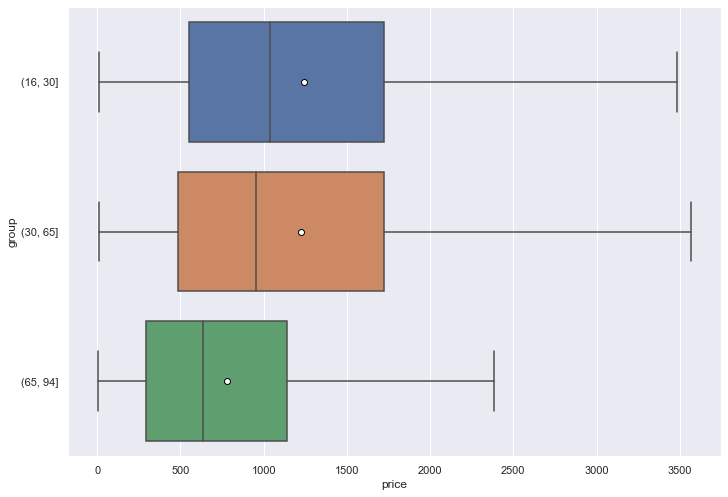


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group,nombre
0,"(16, 30]",601
1,"(30, 65]",1259
2,"(65, 94]",305



Vérifions la normalité:


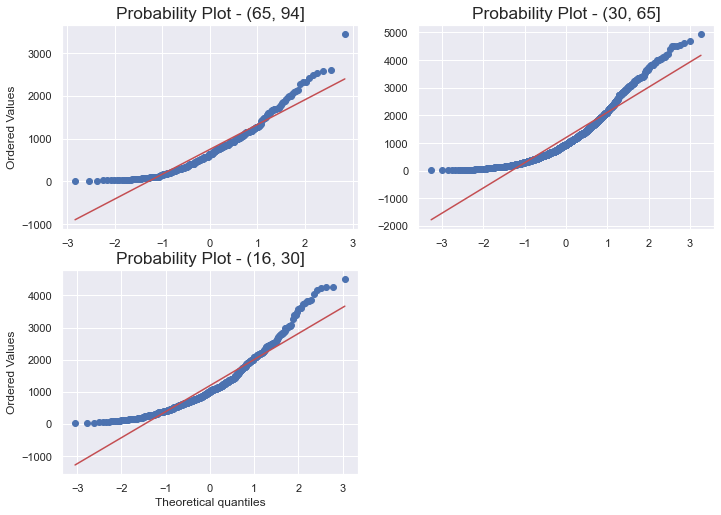


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (65, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (65, 94] ne suit pas une loi normale.
     Groupe (30, 65]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 65] ne suit pas une loi normale.
     Groupe (16, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (16, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.59. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [57]:
sample = prep_anova(df2, "client_id", "group", "price")

In [58]:
anova_table = anova(sample, "group", "price")

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,52205583.337684,2,26102791.668842,33.155236,0.0,3.695181,0.029758
Within Groups,1702121383.459949,2162,787290.186614,,,,
Total,1754326966.797633,2164,810687.138077,,,,


En utilisant la valeur critique:
F-score: 33.16 > critical value: 3.70:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.
------------------------------------------------------------------
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1   group2   meandiff p-adj    lower     upper   reject
-------------------------------------------------------------
(16, 30] (30, 65]    4.3845 0.9945  -98.7908  107.5598  False
(16, 30] (65, 94] -443.3544    0.0 -589.6551 -297.0538   True
(30, 65] (65, 94] -447.7389   -0.0 -580.5471 -314.9307   True
-------------------------------------------------------------


## <p style="text-indent:50px;">Age et fréquence</p>

In [59]:
df3 = df2.copy()
df3 = df3.loc[~df3.freq.isna()]
df3["freq"] /= pd.Timedelta(days=1)

freq                                                              \
           count       mean        std  min        25%        50%        75%   
group                                                                          
(16, 30]  2386.0  56.602487  54.575336  1.0  26.224359  41.031250  67.861111   
(30, 65]  5536.0  31.276052  33.499130  1.0  11.892479  21.352941  38.057292   
(65, 94]  1144.0  36.041565  35.626233  2.5  13.274764  25.208333  44.139286   

                 
            max  
group            
(16, 30]  548.0  
(30, 65]  549.0  
(65, 94]  365.0

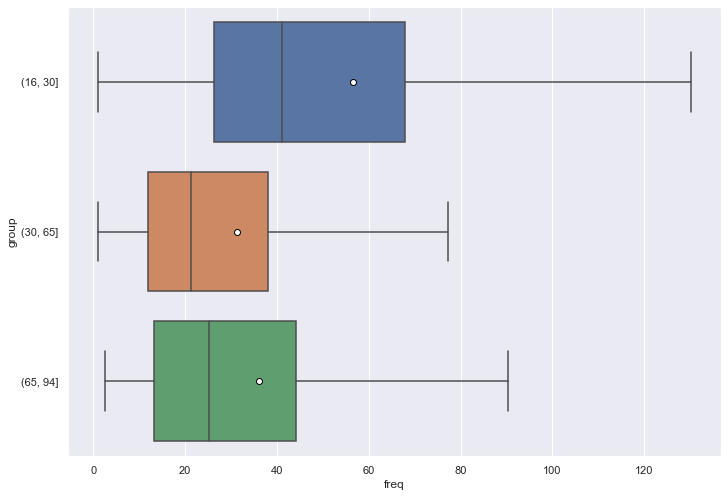


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group,nombre
0,"(16, 30]",553
1,"(30, 65]",1306
2,"(65, 94]",315



Vérifions la normalité:


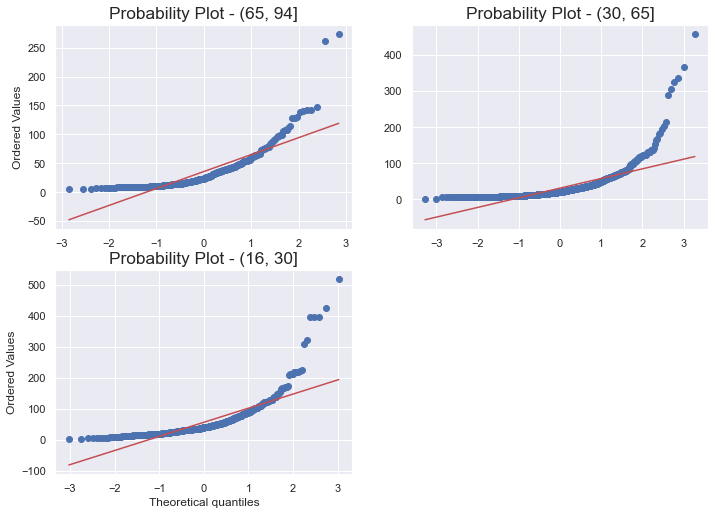


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (65, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (65, 94] ne suit pas une loi normale.
     Groupe (30, 65]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 65] ne suit pas une loi normale.
     Groupe (16, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (16, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 1.63. Il est donc bien inférieur à 2, nous pouvons réaliser l'ANOVA.


In [60]:
sample = prep_anova(df3, "client_id", "group", "freq")

In [61]:
anova_table = anova(sample, "group", "freq")

,SS,df,MS,F,P-value,F crit,eta squared
Source of Variation,,,,,,,
Between Groups,257720.886708,2,128860.443354,76.568694,0.0,3.695155,0.06589
Within Groups,3653660.627793,2171,1682.939027,,,,
Total,3911381.514501,2173,1799.991493,,,,


En utilisant la valeur critique:
F-score: 76.57 > critical value: 3.70:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------
En utilisant la p-value:
p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.
------------------------------------------------------------------
Réalisons un test de tukey afin de voir quels groupes créent cette dépendance:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
(16, 30] (30, 65] -25.6365    0.0 -30.5179 -20.7552   True
(16, 30] (65, 94] -20.9879    0.0 -27.7796 -14.1962   True
(30, 65] (65, 94]   4.6486 0.1681  -1.3909  10.6881  False
----------------------------------------------------------


## <p style="text-indent:50px;">Age et panier moyen</p>

panier_moyen                                                    \
                count       mean        std   min        25%        50%   
group                                                                     
(16, 30]       2409.0  40.139416  18.298893  4.41  26.964118  38.849123   
(30, 65]       5545.0  15.405537   6.700685  4.15  12.813849  14.198077   
(65, 94]       1147.0  16.845520   3.623641  3.99  15.045268  16.559231   

                              
                75%      max  
group                         
(16, 30]  50.369744  181.990  
(30, 65]  16.371154  164.235  
(65, 94]  18.199464   62.250

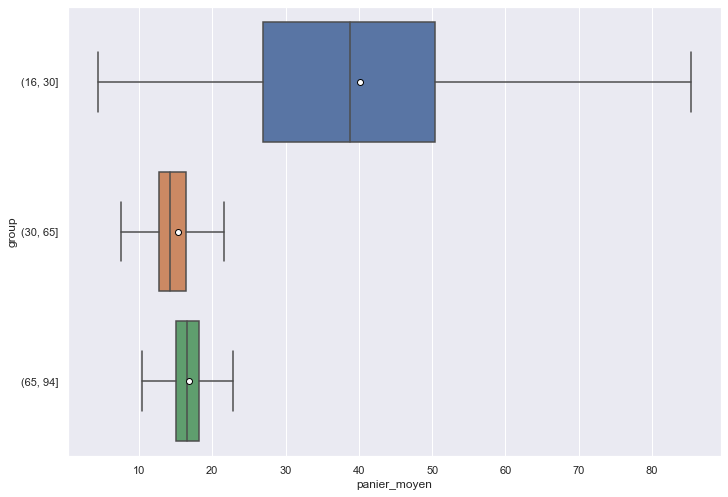


 ------------------------------------------------------------

Création de l'échantillon:
Répartition dans chaque groupe:


,group,nombre
0,"(16, 30]",601
1,"(30, 65]",1259
2,"(65, 94]",305



Vérifions la normalité:


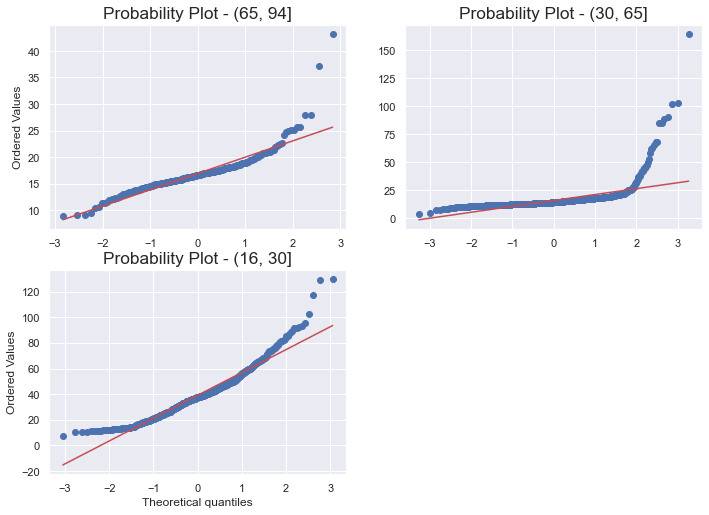


 ------------------------------------------------------------

Test de Shapiro-Wilk:
     Groupe (65, 94]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (65, 94] ne suit pas une loi normale.
     Groupe (30, 65]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (30, 65] ne suit pas une loi normale.
     Groupe (16, 30]:
p-value = 0.00 < 0.05: On rejette H0 à 5%. Le groupe (16, 30] ne suit pas une loi normale.

 ------------------------------------------------------------

Vérifions l'homogénéité de la variance:

Le ratio vaut 5.41. Il est supérieur à 2. Nous ne pouvons pas réaliser l'ANOVA.


In [62]:
sample = prep_anova(df2, "client_id", "group", "panier_moyen")

In [63]:
res.levene(df=sample, res_var='panier_moyen', xfac_var='group')
res.levene_summary

,Parameter,Value
0,Test statistics (W),303.2977
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


In [64]:
kw(sample, "group", "panier_moyen")

p-value: 0.00 <= 0.05:
        On rejette H0 à 5%. Les deux variables sont dépendantes.

 Réalisons un test de Nemenyi afin de voir quelles moyennes ne sont pas égales.

------------------------------------------------------

Pour (16, 30] - (30, 65]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

------------------------------------------------------

Pour (16, 30] - (65, 94]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.

------------------------------------------------------

Pour (30, 65] - (65, 94]:
p-value = 0.00 < 5%. On rejette H0 à 5%. Les deux moyennes sont significativement différentes.
La dépendance de nos deux variables s'expliquent en partie à travers ces 2 groupes.


## <p style="text-indent:50px;">Age et catégorie</p>

In [65]:
cont = df[["categ", "group"]].pivot_table(index = "categ", columns = "group", aggfunc = len, margins = True, margins_name = "total")
cont

group,"(16, 30]","(30, 65]","(65, 94]",total
categ,,,,
0.0,20825,326752,22492,370069
1.0,29155,151339,30283,210777
2.0,28733,2566,481,31780
total,78713,480657,53256,612626


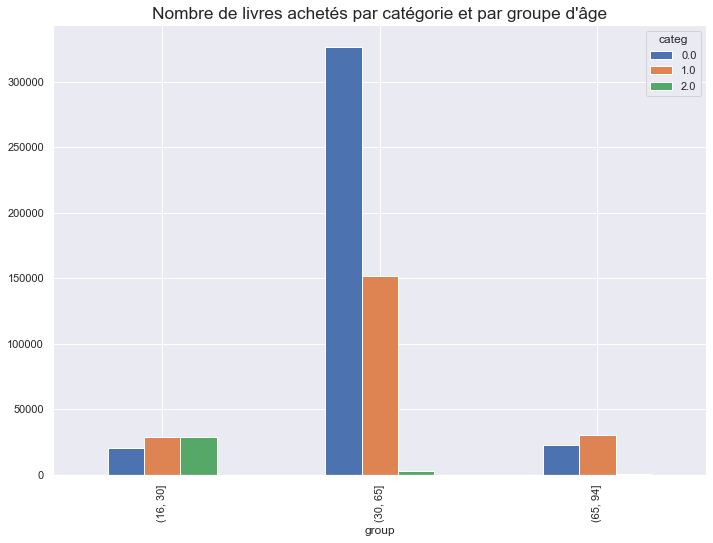

In [66]:
cont.loc[cont.index != "total",cont.columns != "total"].T.plot(kind = "bar", title = "Nombre de livres achetés par catégorie et par groupe d'âge");

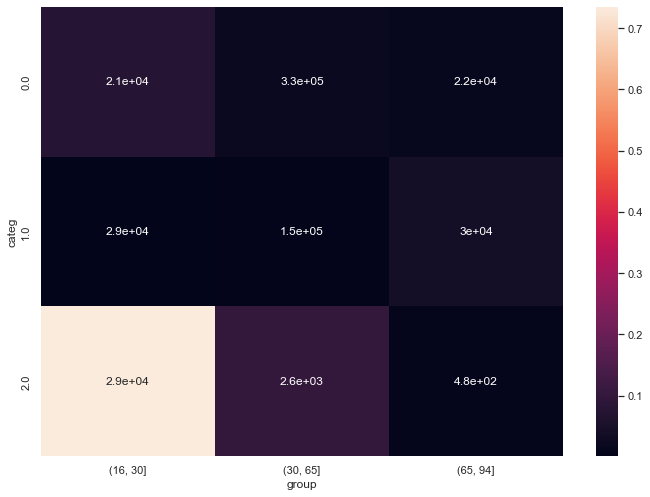

In [67]:
heatmap(cont)

In [68]:
chi2_contingence(cont.iloc[:-1,:-1])

degré de liberté: 4

En utilisant les valeurs critiques:
statistique du chi2: 2.0241e+05
statistique du chi2 > 9.49:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.

--------------------------------------------------------------------------------------

En utilisant la p-value:
p-value: 0
p-value <= 0.05:
On rejette l'hypothèse nulle à 5%. Les deux variables sont dépendantes.
